In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import itertools
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Best Subset Selection

Here we apply the best subset selection approach to the Hitters data. We
wish to predict a baseball player’s Salary on the basis of various statistics
associated with performance in the previous year. Let's take a quick look:

In [2]:
df = pd.read_csv('Hitters.csv')
df.head()

,Player,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,-Andy Allanson,293,66,1,30,29,14,1,293,66,...,30,29,14,A,E,446,33,20,NaN,A
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N


First of all, we note that the ${\tt Salary}$ variable is missing for some of the
players. The ${\tt isnull()}$ function can be used to identify the missing observations. It returns a vector of the same length as the input vector, with a ${\tt TRUE}$ value
for any elements that are missing, and a ${\tt FALSE}$ value for non-missing elements.
The ${\tt sum()}$ function can then be used to count all of the missing elements:

In [3]:
print(df["Salary"].isnull().sum())

59


We see that ${\tt Salary}$ is missing for 59 players. The ${\tt dropna()}$ function
removes all of the rows that have missing values in any variable:

In [4]:
# Print the dimensions of the original Hitters data (322 rows x 20 columns)
print(df.shape)

# Drop any rows the contain missing values, along with the player names
df = df.dropna().drop('Player', axis=1)

# Print the dimensions of the modified Hitters data (263 rows x 20 columns)
print(df.shape)

# One last check: should return 0
print(df["Salary"].isnull().sum())

(322, 21)
(263, 20)
0


In [5]:
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])

y = df.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')

# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

We can perform best subset selection by identifying the best model that contains a given number of predictors, where **best** is quantified using RSS. We'll define a helper function to outputs the best set of variables for
each model size:

In [6]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS}

In [7]:
def getBest(k):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

This returns a ${\tt DataFrame}$ containing the best model that we generated, along with some extra information about the model. Now we want to call that function for each number of predictors $k$:

In [8]:
# Could take quite awhile to complete...

models = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
for i in range(1,8):
    models.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  19 models on 1 predictors in 0.08336591720581055 seconds.
Processed  171 models on 2 predictors in 0.49599599838256836 seconds.
Processed  969 models on 3 predictors in 2.466813802719116 seconds.
Processed  3876 models on 4 predictors in 9.892290115356445 seconds.
Processed  11628 models on 5 predictors in 33.187536001205444 seconds.
Processed  27132 models on 6 predictors in 77.92403101921082 seconds.
Processed  50388 models on 7 predictors in 142.52269101142883 seconds.
Total elapsed time: 266.6522948741913 seconds.


Now we have one big $\tt{DataFrame}$ that contains the best models we've generated. Let's take a look at the first few:

In [9]:
models

,RSS,model
1,4.321393e+07,<statsmodels.regression.linear_model.Regressio...
2,3.073305e+07,<statsmodels.regression.linear_model.Regressio...
3,2.941071e+07,<statsmodels.regression.linear_model.Regressio...
4,2.797678e+07,<statsmodels.regression.linear_model.Regressio...
5,2.718780e+07,<statsmodels.regression.linear_model.Regressio...
6,2.639772e+07,<statsmodels.regression.linear_model.Regressio...
7,2.606413e+07,<statsmodels.regression.linear_model.Regressio...


If we want to access the details of each model, no problem! We can get a full rundown of a single model using the ${\tt summary()}$ function:

In [10]:
print(models.loc[2, "model"].summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     416.7
Date:                Mon, 26 Dec 2016   Prob (F-statistic):           5.80e-82
Time:                        16:14:17   Log-Likelihood:                -1907.6
No. Observations:                 263   AIC:                             3819.
Df Residuals:                     261   BIC:                             3826.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Hits           2.9538      0.261     11.335      0.0

This output indicates that the best two-variable model
contains only ${\tt Hits}$ and ${\tt CRBI}$. To save time, we only generated results
up to the best 11-variable model. You can use the functions we defined above to explore as many variables as are desired.

In [11]:
print(getBest(19)["model"].summary())

Processed  1 models on 19 predictors in 0.009126901626586914 seconds.
                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     54.64
Date:                Mon, 26 Dec 2016   Prob (F-statistic):           1.31e-76
Time:                        16:14:18   Log-Likelihood:                -1877.9
No. Observations:                 263   AIC:                             3794.
Df Residuals:                     244   BIC:                             3862.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------

Rather than letting the results of our call to the ${\tt summary()}$ function print to the screen, we can access just the parts we need using the model's attributes. For example, if we want the $R^2$ value:

In [12]:
models.loc[2, "model"].rsquared

0.7614950002332872

Excellent! In addition to the verbose output we get when we print the summary to the screen, fitting the ${\tt OLM}$ also produced many other useful statistics such as adjusted $R^2$, AIC, and BIC. We can examine these to try to select the best overall model. Let's start by looking at $R^2$ across all our models:

In [13]:
# Gets the second element from each row ('model') and pulls out its rsquared attribute
models.apply(lambda row: row[1].rsquared, axis=1)

1    0.664637
2    0.761495
3    0.771757
4    0.782885
5    0.789008
6    0.795140
7    0.797728
dtype: float64

As expected, the $R^2$ statistic increases monotonically as more
variables are included.

Plotting RSS, adjusted $R^2$, AIC, and BIC for all of the models at once will
help us decide which model to select. Note the ${\tt type="l"}$ option tells ${\tt R}$ to
connect the plotted points with lines:

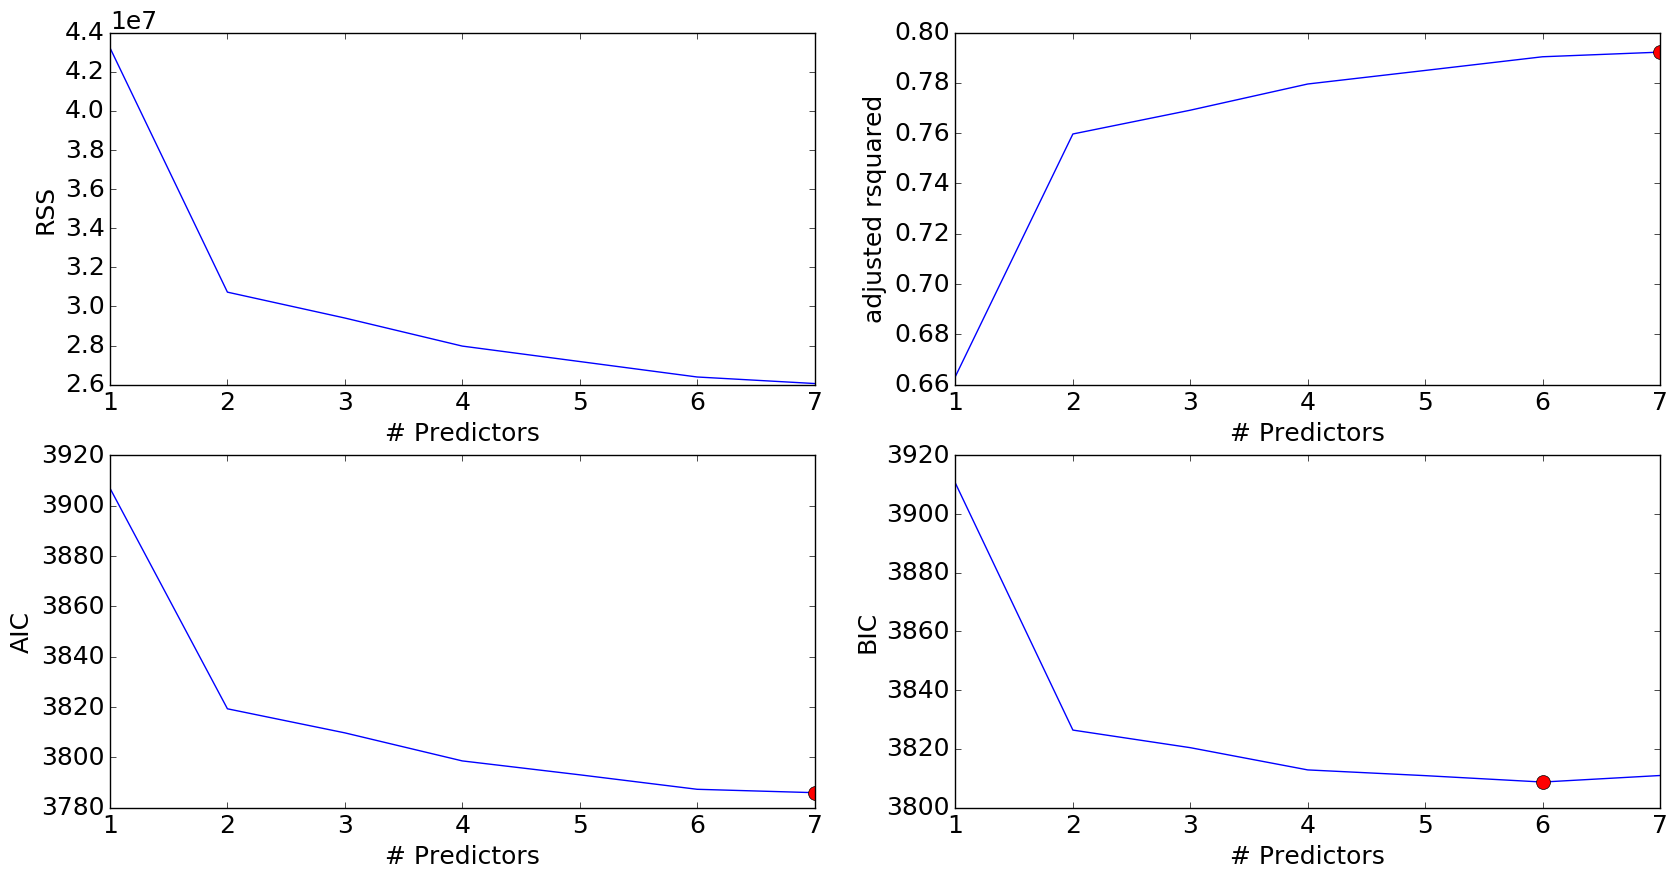

In [14]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax(), rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin(), aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin(), bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

Recall that in the second step of our selection process, we narrowed the field down to just one model on any $k<=p$ predictors. We see that according to BIC, the best performer is the model with 6 variables. According to AIC and adjusted $R^2$ something a bit more complex might be better. Again, no one measure is going to give us an entirely accurate picture... but they all agree that a model with 5 or fewer predictors is insufficient.

# Forward and Backward Stepwise Selection
We can also use a similar approach to perform forward stepwise
or backward stepwise selection, using a slight modification of the functions we defined above:

In [15]:
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

Now let's see how much faster it runs!

In [16]:
models2 = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
predictors = []

for i in range(1,len(X.columns)+1):    
    models2.loc[i] = forward(predictors)
    predictors = models2.loc[i]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  19 models on 1 predictors in 0.0505518913269043 seconds.
Processed  18 models on 2 predictors in 0.04657912254333496 seconds.
Processed  17 models on 3 predictors in 0.04230785369873047 seconds.
Processed  16 models on 4 predictors in 0.042437076568603516 seconds.
Processed  15 models on 5 predictors in 0.051277875900268555 seconds.
Processed  14 models on 6 predictors in 0.03883790969848633 seconds.
Processed  13 models on 7 predictors in 0.03919506072998047 seconds.
Processed  12 models on 8 predictors in 0.04178500175476074 seconds.
Processed  11 models on 9 predictors in 0.031916141510009766 seconds.
Processed  10 models on 10 predictors in 0.029903888702392578 seconds.
Processed  9 models on 11 predictors in 0.0332798957824707 seconds.
Processed  8 models on 12 predictors in 0.02799391746520996 seconds.
Processed  7 models on 13 predictors in 0.021502017974853516 seconds.
Processed  6 models on 14 predictors in 0.021746158599853516 seconds.
Processed  5 models on 15 pre

Phew! That's a lot better. Let's take a look:

In [17]:
print(models.loc[1, "model"].summary())
print(models.loc[2, "model"].summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     519.2
Date:                Mon, 26 Dec 2016   Prob (F-statistic):           4.20e-64
Time:                        16:14:20   Log-Likelihood:                -1952.4
No. Observations:                 263   AIC:                             3907.
Df Residuals:                     262   BIC:                             3910.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Hits           4.8833      0.214     22.787      0.0

We see that using forward stepwise selection, the best one-variable
model contains only ${\tt Hits}$, and the best two-variable model additionally
includes ${\tt CRBI}$. Let's see how the models stack up against best subset selection:

In [18]:
print(models.loc[6, "model"].summary())
print(models2.loc[6, "model"].summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     166.3
Date:                Mon, 26 Dec 2016   Prob (F-statistic):           1.79e-85
Time:                        16:14:20   Log-Likelihood:                -1887.6
No. Observations:                 263   AIC:                             3787.
Df Residuals:                     257   BIC:                             3809.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
AtBat         -1.5488      0.477     -3.248      0.0

For this data, the best one-variable through six-variable
models are each identical for best subset and forward selection.

# Backward Selection
Not much has to change to implement backward selection... just looping through the predictors in reverse!

In [19]:
def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [20]:
models3 = pd.DataFrame(columns=["RSS", "model"], index = range(1,len(X.columns)))

tic = time.time()
predictors = X.columns

while(len(predictors) > 1):  
    models3.loc[len(predictors)-1] = backward(predictors)
    predictors = models3.loc[len(predictors)-1]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  19 models on 18 predictors in 0.06220507621765137 seconds.
Processed  18 models on 17 predictors in 0.05577898025512695 seconds.
Processed  17 models on 16 predictors in 0.05248594284057617 seconds.
Processed  16 models on 15 predictors in 0.048155784606933594 seconds.
Processed  15 models on 14 predictors in 0.04673290252685547 seconds.
Processed  14 models on 13 predictors in 0.041522979736328125 seconds.
Processed  13 models on 12 predictors in 0.036897897720336914 seconds.
Processed  12 models on 11 predictors in 0.03578591346740723 seconds.
Processed  11 models on 10 predictors in 0.031049013137817383 seconds.
Processed  10 models on 9 predictors in 0.02965998649597168 seconds.
Processed  9 models on 8 predictors in 0.024616003036499023 seconds.
Processed  8 models on 7 predictors in 0.023131847381591797 seconds.
Processed  7 models on 6 predictors in 0.01901102066040039 seconds.
Processed  6 models on 5 predictors in 0.015815019607543945 seconds.
Processed  5 models on

For this data, the best one-variable through six-variable
models are each identical for best subset and forward selection.
However, the best seven-variable models identified by forward stepwise selection,
backward stepwise selection, and best subset selection are different:

In [21]:
print(models.loc[7, "model"].params)

Hits            1.680029
Walks           3.399961
CAtBat         -0.328835
CHits           1.347017
CHmRun          1.349373
PutOuts         0.248166
Division_W   -111.943760
dtype: float64


In [22]:
print(models2.loc[7, "model"].params)

Hits            7.277149
CRBI            0.652415
Division_W   -110.656338
PutOuts         0.259787
AtBat          -1.644651
Walks           3.684324
League_N       49.978410
dtype: float64


In [23]:
print(models3.loc[7, "model"].params)

AtBat         -1.601655
Hits           6.148449
Walks          5.866033
CRuns          1.097453
CWalks        -0.650614
PutOuts        0.310125
Division_W   -95.027171
dtype: float64
